# Onsala-1: Extracting Science from the data

In the previous notebook, we have fitted the spectra with our model. Now it is turn to do science with the obtained fitting. Our goal is to estimate the column density from this spectrum, which we can find by integrating the area under the spectral line. First let's see how good was our fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from glob import glob
import astropy.constants as con
import utils as utl
from scipy.optimize import minimize
import dynesty
from scipy import stats
import pickle
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import matplotlib.gridspec as gd
from scipy.integrate import simpson
import juliet

Loading the pickle file containing the data and the fitting...

In [2]:
post = pickle.load(open('Onsala1.pkl', 'rb'), encoding='latin1')

# Loading the data
velo, temp = post['Data']['velocity_m/s'], post['Data']['temp_k']

# And the dictionary containing the samples
samps_dict = post['samples']
samps_keys = list(samps_dict.keys())

# Computing the median best fitted model
med_best_fit = np.zeros(14)

for i in range(len(samps_keys)):
    med_best_fit[i] = np.median(samps_dict[samps_keys[i]])
med_model = utl.model(velo, *med_best_fit)
## And residuals
resid = temp-med_model

(0.0, 90.0)

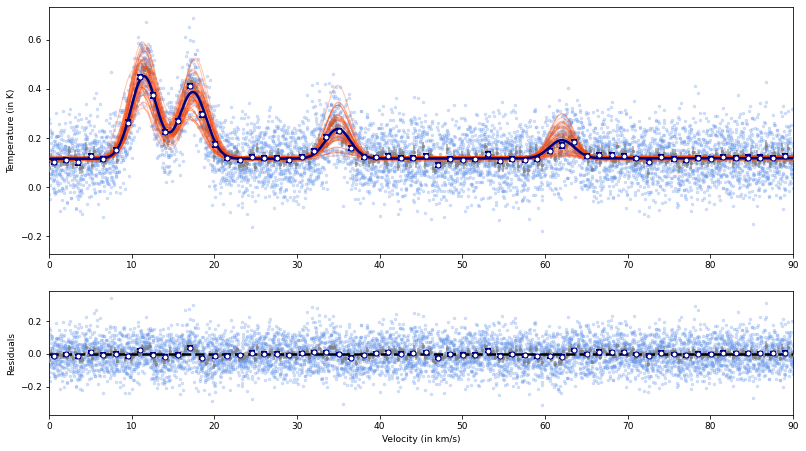

In [3]:
# For binning
## Top panel
vbin1, tbin1, tebin1, _ = utl.lcbin(velo, temp, binwidth=250)
vbin, tbin, tebin, _ = utl.lcbin(velo, temp, binwidth=1500)
## Bottom panel
_, re_bin1, ree_bin1, _ = utl.lcbin(velo, resid, binwidth=250)
_, re_bin, ree_bin, _ = utl.lcbin(velo, resid, binwidth=1500)

# Visualising the results
fig = plt.figure(figsize=(16/1.2,9/1.2))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(velo/1e3, temp, fmt='.', alpha=0.25, c='cornflowerblue')
ax1.errorbar(vbin/1e3, tbin, yerr=tebin, fmt='o', c='navy', elinewidth=2, capthick=2, capsize=3, mfc='white', zorder=150)
ax1.errorbar(vbin1/1e3, tbin1, yerr=tebin1, fmt='.', c='gray', alpha=0.7, zorder=50)
ax1.plot(velo/1e3, med_model, c='navy', zorder=100, lw=2.5)
for i in range(50):
    rand_model_param = np.zeros(14)
    for j in range(len(samps_keys)):
        rand_model_param[j] = np.random.choice(samps_dict[samps_keys[j]], replace=False)
    random_model = utl.model(velo, *rand_model_param)
    ax1.plot(velo/1e3, random_model, c='orangered', zorder=75, lw=1, alpha=0.3)
ax1.set_ylabel('Temperature (in K)')
ax1.set_xlim([0,90])

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(velo/1e3, resid, fmt='.', alpha=0.25, c='cornflowerblue')
ax2.axhline(y=0.0, c='black', ls='--', zorder=100, lw=2.5)
ax2.errorbar(vbin/1e3, re_bin, yerr=ree_bin, fmt='o', c='navy', elinewidth=2, capthick=2, capsize=3, mfc='white', zorder=150)
ax2.errorbar(vbin1/1e3, re_bin1, yerr=ree_bin1, fmt='.', c='gray', alpha=0.7, zorder=50)
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Velocity (in km/s)')
ax2.set_xlim([0,90])
#ax2.set_ylim([-200,200])

## Calculation of the column density

We now have four lines, and we want to compute the column density for each. We can use,

\begin{equation}
N_u = \frac{8\pi k_B \nu^2}{hc^3A_{ul}\eta_{mb}} \int T_A dv
\end{equation}

Here, $N_u$ is the column density for a given line (with frequency $\nu$ in $GHz$), $A_{ul}$ is the Einstein's coefficient for a spontaneous emission. $\eta_{mb}$ is the efficiency of the main beam at these frequncies ($\sim 0.5$). All other symbols have their usual meanings. From our observations (presented in above figure), we can compute the integration.

First, let's compute the Einstein's coefficinet for each line,

\begin{equation*}
A_{ul} = 1.165 \times 10^{−11} \nu^3 \times \mu^2 \frac{J_u^2 - K^2}{J_u (2J_u + 1)}
\end{equation*}

with $\nu$ in $GHz$ and $\mu = 0.75 Debye$. The angular momentum of the upper state of each line ($J_u$) is fixed to 6 for each of our lines. Below, we write a function that can compute $A_{ul}$ from $\nu$ ($K$ can be determined from $\nu$).

In [4]:
def aul(nu):
    coeff = 1.165 * (10**(-11)) * (nu**3) * (0.75**2)
    if nu == 102.5479:
        k = 0
    elif nu == 102.5459:
        k = 1
    elif nu == 102.5398:
        k = 2
    elif nu == 102.5303:
        k = 3
    else:
        raise AttributeError(r'Enter a proper value of $\nu$.')
    ab = (36 - (k*k))/(6*13)
    return coeff*ab

Now, the major task is to compute the integration in Eq. (1). We can use numerical integration techniques (in-build in `scipy.integrate`) to perform this integration. To propagate the errors, we will perform the integration for _each_ point from our posterior sample. That way, we will have posterior distribution for $N_u$.

First we will write a code that can perform the numerical integration given the parameters for the Gaussian line profile. We will then use this function to compute the column density.

In [5]:
def t_dv(x, amp, mu, sig):
    model = utl.gaus(x, amp, mu, sig)
    ints = simpson(model, x)
    return ints

def col_density(x, amp, mu, sig, nu):
    coeff1 = 8 * np.pi * con.k_B.value * nu * nu * (10**(18))
    coeff2 = con.h.value * (con.c.value**3) * aul(nu) * 0.5
    inte = t_dv(x, amp, mu, sig)
    return (coeff1/coeff2)*inte

Let's compute the posterior distribution for the column density for each lines.

In [6]:
nu_k0, nu_k1, nu_k2, nu_k3 = np.zeros(len(samps_dict['a_1'])), np.zeros(len(samps_dict['a_1'])),\
    np.zeros(len(samps_dict['a_1'])), np.zeros(len(samps_dict['a_1']))

nus = [nu_k0, nu_k1, nu_k2, nu_k3]
freqs = np.array([102.5479, 102.5459, 102.5398, 102.5303])
for i in range(len(freqs)):
    for j in range(len(nu_k0)):
        nus[i][j] = col_density(velo, samps_dict['a_' + str(i+1)][j],\
             samps_dict['mu_' + str(i+1)][j], samps_dict['sigma_' + str(i+1)][j], freqs[i])

We now need to calculate the statistical weights for each lines as, $g_u = g_K g_I (2J_u + 1)$. Here,

$g_K=1, \ \ if \ \ K=0$
and, $g_K=2, \ \ if \ \ K\neq0$

Also,

$g_I = 1/2, \ \ K=0,3,6,9,...$ and $g_I = 1/4, \ \ K\neq0,3,6,9,...$

This means that from the value of $K$, we can compute the statistical weight. Using this, we will then calculate $N_u/g_u$ for each line, which we do below.

In [7]:
def gu(kk):
    if kk == 0:
        gk = 1
    else:
        gk = 2
    if kk == 0 or kk == 3:
        gi = 0.5
    else:
        gi = 0.25
    return gk*gi*13

nu_k0g, nu_k1g, nu_k2g, nu_k3g = nu_k0/gu(0), nu_k1/gu(1), nu_k2/gu(2), nu_k3/gu(3)

# And their natural logarithm
ln_nu_k0g, ln_nu_k1g, ln_nu_k2g, ln_nu_k3g = np.log(nu_k0g), np.log(nu_k1g),\
     np.log(nu_k2g), np.log(nu_k3g)
ln_nu = [ln_nu_k0g, ln_nu_k1g, ln_nu_k2g, ln_nu_k3g]

# Tempratures for each line
e_by_k = np.array([17.22, 24.43, 46.03, 82.03])

We can now plot $\ln{(N_u/g_u)}$ vs $E/k_B$,

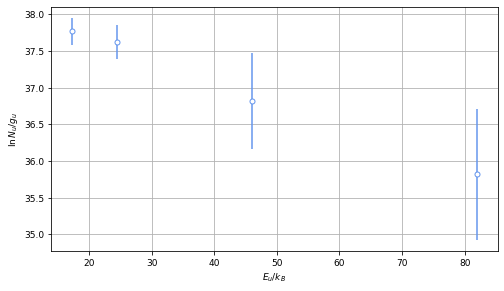

In [8]:
plt.figure(figsize=(8,4.5))
for i in range(len(e_by_k)):
    plt.errorbar(e_by_k[i], np.median(ln_nu[i]), yerr=np.std(ln_nu[i]), fmt='o',\
         c='cornflowerblue', mfc='white')
plt.xlabel(r'$E_u/k_B$')
plt.ylabel(r'$\ln{N_u/g_u}$')
plt.grid()

Let's fit a line to this data. Again, to propagate the errors properly, we will fit the lines to each data point in the posterior sample of $\ln({N_u/g_u})$ using `scipy.optimize.minimize`.

In [9]:
ms, cs = np.zeros(len(ln_nu[0])), np.zeros(len(ln_nu[0]))

for i in range(len(ms)):
    def sqrd_resid(x):
        m1, c1 = x
        mods = utl.line(e_by_k, m1, c1)
        data = np.array([ln_nu[0][i], ln_nu[1][i], ln_nu[2][i], ln_nu[3][i]])
        chi2 = (data-mods)**2
        return 0.5*np.sum(chi2)/2
    soln = minimize(sqrd_resid, x0=[-0.03, -3.], method='BFGS')
    ms[i], cs[i] = soln.x[0], soln.x[1]

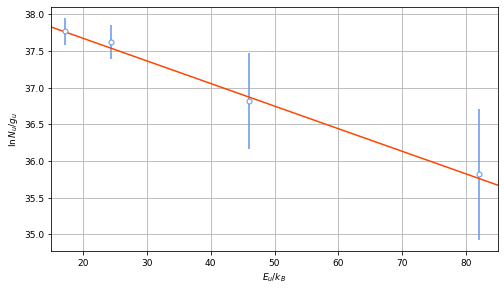

In [10]:
xs1 = np.linspace(15, 85, 100)
best_fit_line = utl.line(xs1, np.median(ms), np.median(cs))

plt.figure(figsize=(8,4.5))
for i in range(len(e_by_k)):
    plt.errorbar(e_by_k[i], np.median(ln_nu[i]), yerr=np.std(ln_nu[i]), fmt='o',\
         c='cornflowerblue', mfc='white')
plt.plot(xs1, best_fit_line, color='orangered', lw=1.5)
plt.xlabel(r'$E_u/k_B$')
plt.ylabel(r'$\ln{N_u/g_u}$')
plt.xlim([15,85])
plt.grid()

We know that the slope of this line is $-1/T$ and the y-intersection at $x=0$ is $\ln(N/Z)$ with $Z = 0.523 \times T^{1.5}$. Using both of these equation, we can compute the temperature and the total column density as follows:

In [11]:
# Temperature of the cloud
temp = -1/ms
temp_qua = juliet.utils.get_quantiles(temp)

# For the column density
zz1 = 0.523 * (temp**1.5)
tot_col_den = np.exp(cs)*zz1
tot_col_den_qua = juliet.utils.get_quantiles(tot_col_den)

print('Temperature of the cloud is: {:.4f} (+{:.4f}) (-{:.4f}) K'.format(temp_qua[0], temp_qua[1]-temp_qua[0], temp_qua[0]-temp_qua[2]))
print('Total column density: {:.4e} (+{:.4e}) (-{:.4e}) 1/m2'.format(tot_col_den_qua[0], tot_col_den_qua[1]-tot_col_den_qua[0], tot_col_den_qua[0]-tot_col_den_qua[2]))

Temperature of the cloud is: 32.4594 (+12.8927) (-10.5499) K
Total column density: 4.1810e+18 (+1.3779e+18) (-9.4188e+17) 1/m2
